### Домашнее задание 1 

<details>
  <summary>Формулировка</summary>

1. Загрузите датасет артефактов вредоносного ПО, хранящихся в памяти - cybersequrity.csv
2. Подготовьте данные к обучению - **1 балл**
    - Разделите датасет на обучающую, валидационную и тестовую выборки со стратификацией в пропорции 60/20/20. В качестве целевой переменной используйте столбец `Class` - бинарный столбец (0 - нейтральное ПО, 1 - вредоносное ПО).
    - **hint**: для ускорения сходимости и стабилизации обучения можно стандартизировать входные признаки, например, с помощью `StandardScaler`
    - Создайте объекты для работы с данными в PyTorch - `Dataset` и `DataLoader` для обучающей, валидационной и тестовой выборок. Выберите оптимальный, на ваш взгляд, `batch_size`.
3. Реализуйте класс бейзлайновой нейросетевой модели (MLP) для решения задачи - **2 балла**
    - Определите оптимальное количество `Linear` слоев в структуре и их размерности.
    - Подберите оптимальные для задачи функции активации - `ReLU`, `Sigmoid`, `Tanh`, `LeakyReLU`...
    - Реализуйте логику прохождения данных по сети в методе `forward`
    - Cоздайте объект модели, реализуйте перевод модели на gpu
4. Напишите код цикла обучения - train-loop и валидации - eval-loop. В процессе обучения сохраняйте и визуализируйте на графике динамику функции потерь на тренировочной и валидационной выборках - **1 балл**
5. Обучите модель и проверьте ее качество - **1 балл**
    - Выберите оптимизатор, в качестве функции потерь используйте `nn.BCELoss`
    - Запустите обучение, постарайтесь подобрать оптимальные скорость обучения и количество эпох, ориентируясь на динамику функции потерь на train/val
    - Измерьте качество лучшей модели на тестовой выборке, постройте отчет о классификации - `classification_report`
6. Улучшите архитектуру модели из пункта 3 и добейтесь увеличения качества - **3 балла**
    - Попробуйте добавить слои `BatchNorm1d` и `Dropout` - поэкспериментируйте с их "расположением" в сети, напишите свои выводы о целесообразности их добавления в модель, оптимальном расположении, влиянии на качество/сходимость обучения. При использовании слоя `Dropout` - определите экспериментально или обоснуйте теоретически оптимальное значение параметра `p`.
    - Обучите улучшенную модель и проверьте ее качество (при необходимости измените гиперпараметры обучения - `batch_size`, скорость обучения и количество эпох, ориентируясь на динамику функции потерь на train/val и архитектуру модели)

**Общее**

- Принимаемые решения обоснованы (почему выбрана определенная архитектура/гиперпараметр/оптимизатор/проеобразование и т.п.) - **1 балл**
- Обеспечена воспроизводимость решения: зафиксированы random_state, ноутбук воспроизводится от начала до конца без ошибок - **1 балл**

**Формат сдачи ДЗ**

- Создать отедльный репозиторий (если еще не создавали)
- Выдать доступ в репозиторий своему ментору и pacifikus (распределение по менторам и их ники на гитхабе есть в [таблице](https://docs.google.com/spreadsheets/d/1qneC-kHlNzgkCzRoGA9dgUbDthyQd-FA3GhvLCMQY_M/edit?usp=sharing)
- Каждая домашняя работа – PR в отдельную ветку **hw_n**, где **n** - номер домашней работы
- Добавить ментора и pacifikus в reviewers
- Дождаться ревью, если все ок – мержим в main
- Если не ок – вносим исправления и снова отправляем на ревью

</details>

In [290]:
# библиотеки
import os
import random
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm
from collections import defaultdict

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

### Шаг 1

<details>
  <summary>Формулировка</summary>
  
Загрузите датасет артефактов вредоносного ПО, хранящихся в памяти - cybersequrity.csv
</details>


In [291]:
data = pd.read_csv('../data/cybersequrity.csv')
# посмотрим на данные
data.head()

,svcscan.fs_drivers,callbacks.ngeneric,psxview.not_in_eprocess_pool_false_avg,psxview.not_in_eprocess_pool,callbacks.nanonymous,psxview.not_in_session,psxview.not_in_pslist,psxview.not_in_pspcid_list,psxview.not_in_ethread_pool,psxview.not_in_csrss_handles,psxview.not_in_pslist_false_avg,psxview.not_in_pspcid_list_false_avg,psxview.not_in_deskthrd,psxview.not_in_ethread_pool_false_avg,psxview.not_in_session_false_avg,Class
0,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.044444,1
1,26,8,0.0,0,0,5,3,3,3,7,0.073171,0.073171,9,0.073171,0.121951,1
2,26,8,0.0,0,0,9,7,7,7,11,0.152174,0.152174,13,0.152174,0.195652,1
3,26,8,0.0,0,0,3,1,1,2,6,0.022222,0.022222,9,0.044444,0.066667,1
4,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.048780,0


In [292]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   svcscan.fs_drivers                      10000 non-null  int64  
 1   callbacks.ngeneric                      10000 non-null  int64  
 2   psxview.not_in_eprocess_pool_false_avg  10000 non-null  float64
 3   psxview.not_in_eprocess_pool            10000 non-null  int64  
 4   callbacks.nanonymous                    10000 non-null  int64  
 5   psxview.not_in_session                  10000 non-null  int64  
 6   psxview.not_in_pslist                   10000 non-null  int64  
 7   psxview.not_in_pspcid_list              10000 non-null  int64  
 8   psxview.not_in_ethread_pool             10000 non-null  int64  
 9   psxview.not_in_csrss_handles            10000 non-null  int64  
 10  psxview.not_in_pslist_false_avg         10000 non-null  flo

In [293]:
data.describe()

,svcscan.fs_drivers,callbacks.ngeneric,psxview.not_in_eprocess_pool_false_avg,psxview.not_in_eprocess_pool,callbacks.nanonymous,psxview.not_in_session,psxview.not_in_pslist,psxview.not_in_pspcid_list,psxview.not_in_ethread_pool,psxview.not_in_csrss_handles,psxview.not_in_pslist_false_avg,psxview.not_in_pspcid_list_false_avg,psxview.not_in_deskthrd,psxview.not_in_ethread_pool_false_avg,psxview.not_in_session_false_avg,Class
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,25.995400,7.999800,0.000069,0.001700,0.000800,3.859000,1.859300,1.85880,2.299500,6.301900,0.040579,0.040569,8.290700,0.047741,0.087565,0.509600
std,0.210198,0.014141,0.001133,0.041198,0.028274,3.016625,3.016623,3.01645,4.827249,4.828653,0.057255,0.057253,4.945568,0.067768,0.054770,0.499933
min,11.000000,7.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.00000,0.000000,4.000000,0.000000,0.000000,4.000000,0.000000,0.011834,0.000000
25%,26.000000,8.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.00000,0.000000,4.000000,0.000000,0.000000,6.000000,0.000000,0.048780,0.000000
50%,26.000000,8.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.00000,1.000000,5.000000,0.020997,0.020997,7.000000,0.023256,0.066667,1.000000
75%,26.000000,8.000000,0.000000,0.000000,0.000000,5.000000,3.000000,3.00000,3.000000,7.000000,0.068182,0.068182,9.000000,0.071429,0.113636,1.000000
max,26.000000,8.000000,0.027778,1.000000,1.000000,37.000000,35.000000,35.00000,139.000000,143.000000,0.500000,0.500000,145.000000,0.771084,0.528571,1.000000


In [294]:
# посмотрим на целевую переменную и ее сбалансированность (столбец Class - бинарный столбец (0 - нейтральное ПО, 1 - вредоносное ПО)
print(data['Class'].value_counts())

print('__' * 22)
# проверим наличие пропущенных значений
print(data.isnull().sum())

Class
1    5096
0    4904
Name: count, dtype: int64
____________________________________________
svcscan.fs_drivers                        0
callbacks.ngeneric                        0
psxview.not_in_eprocess_pool_false_avg    0
psxview.not_in_eprocess_pool              0
callbacks.nanonymous                      0
psxview.not_in_session                    0
psxview.not_in_pslist                     0
psxview.not_in_pspcid_list                0
psxview.not_in_ethread_pool               0
psxview.not_in_csrss_handles              0
psxview.not_in_pslist_false_avg           0
psxview.not_in_pspcid_list_false_avg      0
psxview.not_in_deskthrd                   0
psxview.not_in_ethread_pool_false_avg     0
psxview.not_in_session_false_avg          0
Class                                     0
dtype: int64


In [295]:
# установка всевозможных random seed
def set_seed(seed: int = 21) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(21)

Random seed set as 21


### Шаг 2

<details>
  <summary>Формулировка</summary>

2. Подготовьте данные к обучению - **1 балл**
    - Разделите датасет на обучающую, валидационную и тестовую выборки со стратификацией в пропорции 60/20/20. В качестве целевой переменной используйте столбец `Class` - бинарный столбец (0 - нейтральное ПО, 1 - вредоносное ПО).
    - **hint**: для ускорения сходимости и стабилизации обучения можно стандартизировать входные признаки, например, с помощью `StandardScaler`
    - Создайте объекты для работы с данными в PyTorch - `Dataset` и `DataLoader` для обучающей, валидационной и тестовой выборок. Выберите оптимальный, на ваш взгляд, `batch_size`.

</details>


#### Разбиение данных и стандартизация StandardScaler

In [296]:
# Убираем целевой столбец из данных и разделяем данные на признаки и целевую переменную
X = data.drop(columns=['Class'])  
y = data['Class']

# Разделяем данные на обучающую, тестовую и валидационную выборки 60/20/20
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=21)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=21)

# Стандартизация: только по обучающим данным
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)     # Fit на обучающей выборке
X_val = scaler.transform(X_val)             # Transform на валидационной выборке
X_test = scaler.transform(X_test)           # Transform на тестовой выборке

X_train.shape, X_val.shape, X_test.shape

((6000, 15), (2000, 15), (2000, 15))

#### Подготовка данных для работы в PyTorch - Обертка для данных

(Dataset и DataLoader для обучающей, валидационной и тестовой выборок. Выбор оптимального batch_size)

In [297]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.from_numpy(y.values).reshape(-1, 1).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.y[index])  
    
# Создаем объекты Dataset
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

# Оптимальный batch_size (на мой взгляд лучше взять что-то небольшое)
batch_size = 32

# Создаем DataLoader для каждой выборки
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [298]:
# Пример: Проходимся по одному батчу из обучающей выборки
for batch_features, batch_targets in train_dataloader:
    print("Batch features shape:", batch_features.shape)
    print("Batch targets shape:", batch_targets.shape)
    break

Batch features shape: torch.Size([32, 15])
Batch targets shape: torch.Size([32, 1])


### Шаг 3
<details>
  <summary>Формулировка</summary>

3. Реализуйте класс бейзлайновой нейросетевой модели (MLP) для решения задачи - **2 балла**
    - Определите оптимальное количество `Linear` слоев в структуре и их размерности.
    - Подберите оптимальные для задачи функции активации - `ReLU`, `Sigmoid`, `Tanh`, `LeakyReLU`...
    - Реализуйте логику прохождения данных по сети в методе `forward`
    - Cоздайте объект модели, реализуйте перевод модели на gpu

</details>

##### Обоснование выбора функций активации и архитектуры модели

1. **Функции активации**:
   - `ReLU` используется для скрытых слоев, так как она проста, эффективна, быстро сходится и хорошо справляется с проблемой градиентного затухания.
   - `Sigmoid` применяется на выходе модели, так как задача бинарной классификации требует вероятностного выхода в диапазоне [0, 1] а у нас как раз такая задача для определения вредоносного ПО.

2. **Количество слоев**:
   - Выбрано 3 скрытых слоя для достижения баланса между выразительной способностью модели и снижением риска переобучения (и просто на пробу как оптимальное).

3. **Размерности скрытых слоев**:
   - Размерности скрытых слоев выбраны как 128 → 64 → 32, чтобы постепенно уменьшать количество параметров и аггрегировать информацию, сохраняя ключевые признаки.
   - Начальное значение 128 для первого слоя выбрано для эффективной обработки 15 входных признаков и извлечения высокоуровневых представлений.

In [299]:
class BaselineMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, activation_function=nn.ReLU()):
        """
        input_size: Количество входных признаков.
        hidden_sizes: Список размерностей скрытых слоев.
        activation_function: Функция активации для скрытых слоев (по умолчанию ReLU).
        """
        super(BaselineMLP, self).__init__()
        
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(activation_function)
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, 1))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


input_size = X_train.shape[1]
hidden_sizes = [128, 64, 32]

model = BaselineMLP(input_size, hidden_sizes, activation_function=nn.ReLU())
model

BaselineMLP(
  (network): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [300]:
# Переводим модель на GPU (если доступен)
if torch.backends.mps.is_available():
    device = torch.device("mps") 
    print("MPS (Metal) доступен и используется!")
else:
    device = torch.device("cpu")
    print("MPS недоступен, используется CPU")
   
# Переводим модель на устройство mps (ускорение на GPU через Metal Performance Shaders на macOS)
model = model.to(device)

MPS (Metal) доступен и используется!


### Шаг 4
<details>
  <summary>Формулировка</summary>

4. Напишите код цикла обучения - train-loop и валидации - eval-loop. В процессе обучения сохраняйте и визуализируйте на графике динамику функции потерь на тренировочной и валидационной выборках - **1 балл**

</details>

In [301]:
# Функция обучения модели на одной эпохе
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    y_true = []
    y_pred = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Приведение размера targets, если требуется
        if targets.dim() == 1:
            targets = targets.view(-1, 1)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass и обновление весов
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Сохраняем для вычисления F1-score
        preds = (outputs >= 0.5).int()
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    # Вычисление среднего значения функции потерь и F1-score
    avg_loss = running_loss / len(train_loader)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    return avg_loss, f1

# Функция обучения модели на одной эпохе для валиадционной выборки 
def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Приведение размера targets, если требуется
            if targets.dim() == 1:
                targets = targets.view(-1, 1)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()

            # Сохраняем для вычисления F1-score
            preds = (outputs >= 0.5).int()
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Вычисление среднего значения функции потерь и F1-score
    avg_loss = running_loss / len(val_loader)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    return avg_loss, f1

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, eval_freq=10, patience=10):
    train_losses, val_losses = [], []
    train_f1s, val_f1s = [], []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        # Обучение за одну эпоху
        train_loss, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_f1s.append(train_f1)

        # Валидация
        if epoch % eval_freq == 0:
            val_loss, val_f1 = validate_one_epoch(model, val_loader, criterion, device)
            val_losses.append(val_loss)
            val_f1s.append(val_f1)

            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

            # Ранняя остановка
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                torch.save(model.state_dict(), "best_model.pth")  # Сохранение лучшей модели
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print("Early stopping triggered!")
                break

    # Построение графиков
    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plt.plot(range(len(train_losses)), train_losses, label="Train Loss")
    plt.plot(range(len(val_losses)), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    plt.subplot(122)
    plt.plot(range(len(train_f1s)), train_f1s, label="Train F1")
    plt.plot(range(len(val_f1s)), val_f1s, label="Validation F1")
    plt.xlabel("Epochs")
    plt.ylabel("F1-score")
    plt.title("F1-score Over Epochs")
    plt.legend()

    plt.show()

    return model

### Шаг 5
<details>
  <summary>Формулировка</summary>

5. Обучите модель и проверьте ее качество - **1 балл**
    - Выберите оптимизатор, в качестве функции потерь используйте `nn.BCELoss`
    - Запустите обучение, постарайтесь подобрать оптимальные скорость обучения и количество эпох, ориентируясь на динамику функции потерь на train/val
    - Измерьте качество лучшей модели на тестовой выборке, постройте отчет о классификации - `classification_report`

</details>

In [302]:
@torch.no_grad()
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    y_true = []
    y_pred = []
    running_loss = 0.0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)  # Рассчёт функции потерь
            running_loss += loss.item()

            # Преобразование вероятностей в метки
            predictions = (outputs >= 0.5).int()

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    # Средний Loss
    avg_loss = running_loss / len(test_loader)

    # F1-Score
    test_f1 = f1_score(y_true, y_pred, zero_division=1)

    # Вывод метрик
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")

    # Вывод отчёта о классификации
    print(classification_report(y_true, y_pred))

### Обоснование выбора оптимизатора, скорости обучения и количества эпох

1. **Adam:** Выбран за быструю сходимость и адаптивное управление скоростью обучения (подходит хорошо для бинарной классификации). Сравнивала с AdamW, NAdam, Adamax, RMSprop и SGD.
2. **lr = 1e-3:** Уменьшен для стабилизации обучения и предотвращения скачков функции потерь.
3. **75 эпох:** Достаточно для достижения сходимости без признаков переобучения.

Epoch 1/75 | Train Loss: 0.6638 | Val Loss: 0.6568 | Train F1: 0.5915 | Val F1: 0.6923
Epoch 2/75 | Train Loss: 0.6104 | Val Loss: 0.5820 | Train F1: 0.6546 | Val F1: 0.6518
Epoch 3/75 | Train Loss: 0.5607 | Val Loss: 0.5328 | Train F1: 0.7098 | Val F1: 0.7528
Epoch 4/75 | Train Loss: 0.5156 | Val Loss: 0.4945 | Train F1: 0.7463 | Val F1: 0.7648
Epoch 5/75 | Train Loss: 0.4846 | Val Loss: 0.4746 | Train F1: 0.7648 | Val F1: 0.7774
Epoch 6/75 | Train Loss: 0.4808 | Val Loss: 0.4640 | Train F1: 0.7646 | Val F1: 0.7859
Epoch 7/75 | Train Loss: 0.4753 | Val Loss: 0.4549 | Train F1: 0.7658 | Val F1: 0.7886
Epoch 8/75 | Train Loss: 0.4620 | Val Loss: 0.4469 | Train F1: 0.7767 | Val F1: 0.7741
Epoch 9/75 | Train Loss: 0.4500 | Val Loss: 0.4457 | Train F1: 0.7829 | Val F1: 0.7888
Epoch 10/75 | Train Loss: 0.4442 | Val Loss: 0.4744 | Train F1: 0.7901 | Val F1: 0.7851
Epoch 11/75 | Train Loss: 0.4401 | Val Loss: 0.4216 | Train F1: 0.7883 | Val F1: 0.7978
Epoch 12/75 | Train Loss: 0.4294 | Val Lo

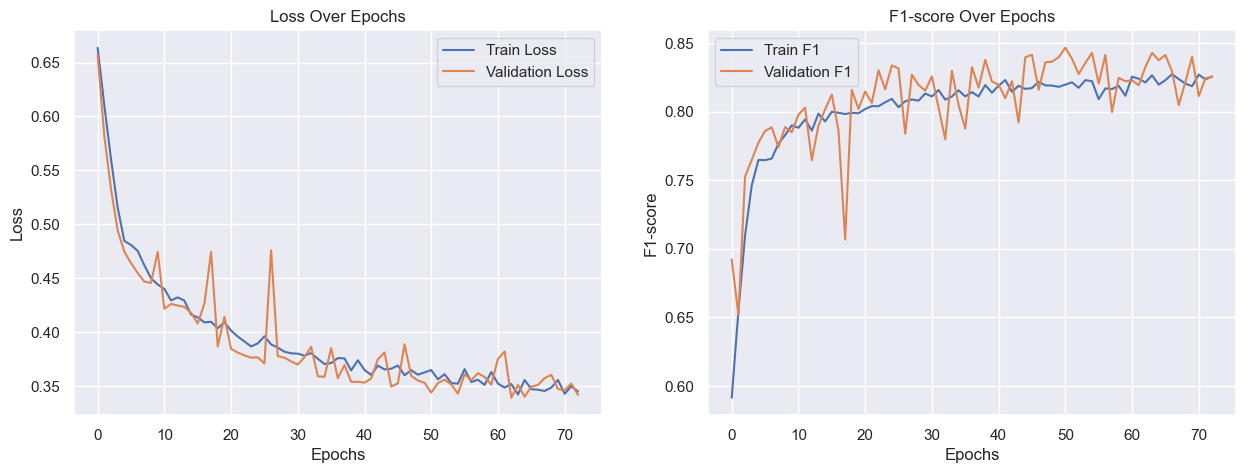

Test Loss: 0.3638
Test F1 Score: 0.8116
              precision    recall  f1-score   support

         0.0       0.77      0.91      0.84       981
         1.0       0.90      0.74      0.81      1019

    accuracy                           0.82      2000
   macro avg       0.83      0.83      0.82      2000
weighted avg       0.84      0.82      0.82      2000



In [303]:
# Настройка функции потерь и оптимизатора
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Запуск обучения
epochs = 75
model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, device, epochs, eval_freq=1, patience=10)

# Оценка на тестовой выборке
evaluate_model(model, test_dataloader, criterion, device)

### Шаг 6
<details>
  <summary>Формулировка</summary>

6. Улучшите архитектуру модели из пункта 3 и добейтесь увеличения качества - **3 балла**
    - Попробуйте добавить слои `BatchNorm1d` и `Dropout` - поэкспериментируйте с их "расположением" в сети, напишите свои выводы о целесообразности их добавления в модель, оптимальном расположении, влиянии на качество/сходимость обучения. При использовании слоя `Dropout` - определите экспериментально или обоснуйте теоретически оптимальное значение параметра `p`.
    - Обучите улучшенную модель и проверьте ее качество (при необходимости измените гиперпараметры обучения - `batch_size`, скорость обучения и количество эпох, ориентируясь на динамику функции потерь на train/val и архитектуру модели)

</details>

In [321]:
class ImprovedMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_prob=0.3):
        super(ImprovedMLP, self).__init__()
        layers = []
        previous_size = input_size

        for hidden_size in hidden_sizes:
            
            layers.append(nn.Linear(previous_size, hidden_size))    # Линейный слой
            layers.append(nn.BatchNorm1d(hidden_size))              # BatchNorm1d перед активацией
            layers.append(nn.ReLU())                                # Активация
            layers.append(nn.Dropout(p=dropout_prob))               # Dropout после активации
            
            previous_size = hidden_size

        # Выходной слой
        layers.append(nn.Linear(previous_size, 1))
        layers.append(nn.Sigmoid())  # Для бинарной классификации

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [322]:
input_size = X_train.shape[1]
hidden_sizes = [128, 64, 32]  
dropout_prob = 0.1           
batch_size = 32              
lr = 1e-3                    

# Создаем DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Инициализация модели
model = ImprovedMLP(input_size=input_size, hidden_sizes=hidden_sizes, dropout_prob=dropout_prob)
model = model.to(device)
model

ImprovedMLP(
  (network): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
    (13): Sigmoid()
  )
)

Epoch 1/50 | Train Loss: 0.6041 | Val Loss: 0.7065 | Train F1: 0.6966 | Val F1: 0.7324
Epoch 2/50 | Train Loss: 0.5481 | Val Loss: 0.6700 | Train F1: 0.7208 | Val F1: 0.7636
Epoch 3/50 | Train Loss: 0.5314 | Val Loss: 0.6129 | Train F1: 0.7258 | Val F1: 0.7255
Epoch 4/50 | Train Loss: 0.5312 | Val Loss: 0.5989 | Train F1: 0.7315 | Val F1: 0.7210
Epoch 5/50 | Train Loss: 0.5044 | Val Loss: 0.5697 | Train F1: 0.7489 | Val F1: 0.7399
Epoch 6/50 | Train Loss: 0.4984 | Val Loss: 0.5761 | Train F1: 0.7492 | Val F1: 0.7490
Epoch 7/50 | Train Loss: 0.4958 | Val Loss: 0.5301 | Train F1: 0.7497 | Val F1: 0.7773
Epoch 8/50 | Train Loss: 0.4908 | Val Loss: 0.5644 | Train F1: 0.7520 | Val F1: 0.7567
Epoch 9/50 | Train Loss: 0.4813 | Val Loss: 0.5838 | Train F1: 0.7570 | Val F1: 0.7262
Epoch 10/50 | Train Loss: 0.4778 | Val Loss: 0.5353 | Train F1: 0.7651 | Val F1: 0.7460
Epoch 11/50 | Train Loss: 0.4852 | Val Loss: 0.4993 | Train F1: 0.7559 | Val F1: 0.7929
Epoch 12/50 | Train Loss: 0.4822 | Val Lo

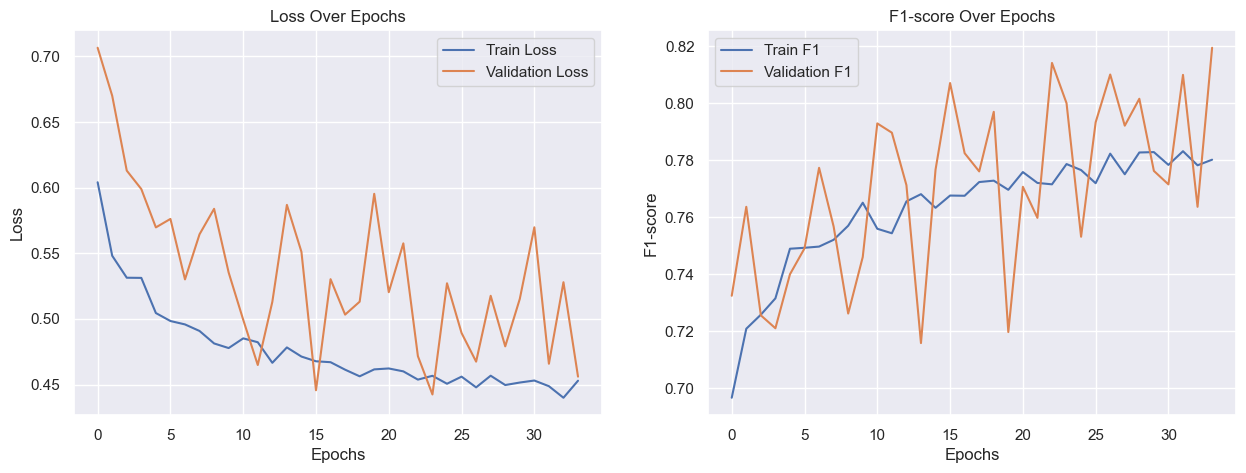

In [323]:
# Настройка оптимизатора
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
# Обучение
epochs = 50
model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, device, epochs, eval_freq=1, patience=10)

In [324]:
# Оценка
evaluate_model(model, test_dataloader, criterion, device)

Test Loss: 0.4653
Test F1 Score: 0.8092
              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80       981
         1.0       0.80      0.82      0.81      1019

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80      2000



### Вывод

При попытке улучшить базовую модель (BaseMLP) путем добавления слоев `BatchNorm1d` и `Dropout`, а также экспериментирования с их расположением и гиперпараметрами, результаты оказались хуже или сопоставимы с базовой моделью.

1. **Гиперпараметры и их влияние:**
   - Размер скрытых слоев `hidden_sizes = [128, 64, 32]` и размер мини-батча `batch_size = 32` оставались неизменными на начальных этапах экспериментов для обеспечения справедливости. Однако добавление `BatchNorm1d` и `Dropout` не привело к улучшению.
   - Параметр `p=0.1` для `Dropout` показал лучшие результаты среди протестированных значений, так как более высокие значения увеличивали потери информации, а более низкие значения не оказывали значительного влияния.
   - Увеличение `batch_size` до 64 дало небольшие улучшения в некоторых экспериментах, но значимого роста качества не произошло. Значения выше 64 (например, 128) ухудшали качество обучения, как и слишком низкие значения (например, 16).

2. **Результаты экспериментов:**
   - Улучшенная модель с добавлением `BatchNorm1d` и `Dropout` показала **Test Loss: 0.4653** и **F1 Score: 0.8092**, что хуже базовой модели (**Test Loss: 0.3638**, **F1 Score: 0.8116**).
   - Анализ отчета о классификации показал, что улучшенная модель имеет высокий перекос в предсказаниях. Например, полнота (`recall`) для класса `1` значительно выше, но за счет низкой полноты класса `0`.

3. **Выводы о добавленных слоях:**
   - `BatchNorm1d` помогал стабилизировать обучение, но в сочетании с `Dropout` его влияние оказалось минимальным.
   - `Dropout` с параметром `p=0.1` помогал избежать переобучения, но более высокие значения вызывали потерю важных данных.
   - Расположение слоев (например, порядок `BatchNorm1d`, `Dropout`, `ReLU`) также не дало значительного прироста.

4. **Итог:**
   - Базовая модель (BaseMLP) остается лучшим решением для текущей задачи.
   - Добавление дополнительных слоев увеличивает сложность модели, но для данной архитектуры и данных это не приводит к росту качества. Это может быть связано с ограничением размера данных или отсутствием сложных нелинейных зависимостей, которые могли бы быть выявлены более сложной архитектурой.